This code is based on the Flow Down Slope notebook in the flowdownslope example. It contains quick analysis for the abyssal mixing case.

In [22]:
%pylab inline
import scipy.io.netcdf
import time
from IPython import display

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [23]:
# These next two lines add the MOM6-examples/tools/analysis/ directory to the search path for python packages
import sys
sys.path.append('../../tools/analysis/')
# m6toolbox is a python package that has a function that helps visualize vertical sections
import m6toolbox

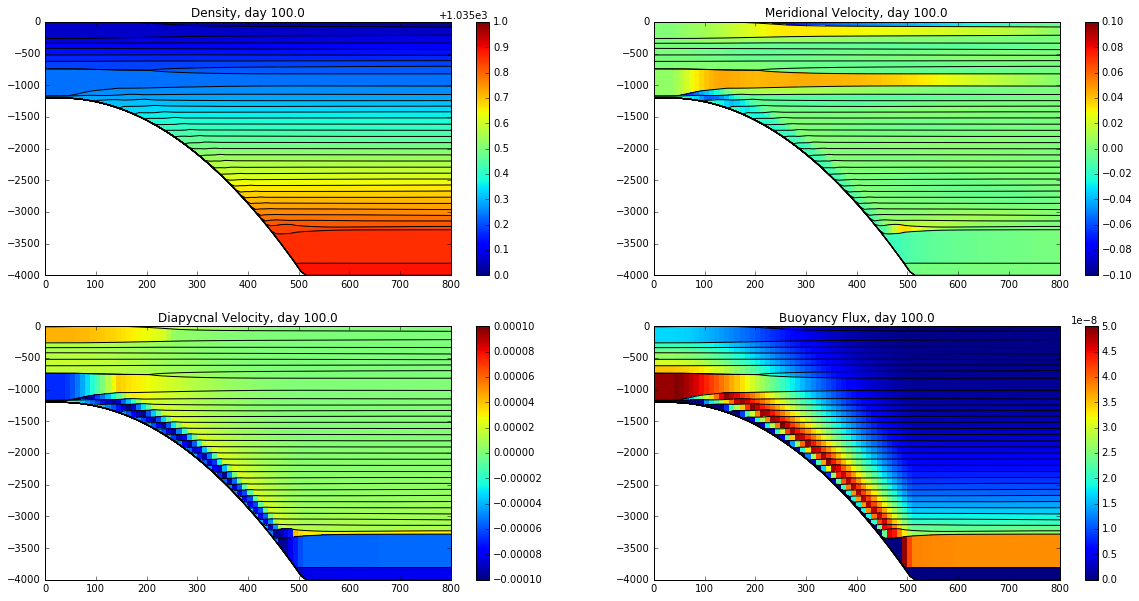

In [53]:
# Open the output:
fname = scipy.io.netcdf_file('prog.nc')

# Read the horizontal coordinate which is the same for all configurations 
yq = fname.variables['yq'][:] # This is the coordinate of the cell corners (u-points in 1D)
yq = numpy.concatenate(([0],yq)) # Inserts left most edge of domain in to coordinates

# Define a function to plot a section
def plot_section(file_handle, record, variable='zl', clim=(1035., 1036.), plot_grid=True, rep='linear'):
    """Plots a section of by reading vertical grid and scalar variable and super-sampling
    both in order to plot vertical and horizontal reconstructions.
    
    Optional arguments have defaults for plotting salinity and overlaying the grid.
    """
    e = file_handle.variables['e'][record,:,:,0] # Vertical grid positions
    if variable == 'zl':
        s = np.tile(file_handle.variables['zl'][:],(len(e[0,:]),1)).T
    else:
        s = file_handle.variables[variable][record,:,:,0] # Scalar field to color

    if (np.shape(s)[0]==np.shape(e)[0]):
        s = (s[1:,:]+s[:-1,:])/2 #NOTE THIS IS DODGY!
    y,z,q = m6toolbox.section2quadmesh(yq, e, s, representation=rep) # This yields three areas at twice the model resolution
    plt.pcolormesh(y, z, q);
    plt.clim(clim)
    if plot_grid: plt.plot(y, z.T, 'k', hold=True);
    plt.ylim(-4000,1)
    plt.xlim(0,800)

record = -1 # record
fig = plt.figure(1, figsize=(20,10))
timevar = fname.variables['Time']
#for record in [record]:
for record in np.arange(0,len(timevar[:]),1):
    plt.clf()
    plt.subplot(2,2,1)
    plot_section(fname, record, variable='zl', clim=(1035.0, 1036.0)); plt.title('Density, day {}'.format(timevar[record])); plt.colorbar()
    plt.subplot(2,2,2)
    plot_section(fname, record, variable='v', clim=(-0.1, 0.1)); plt.title('Meridional Velocity, day {}'.format(timevar[record])); plt.colorbar()
    plt.subplot(2,2,3)
    plot_section(fname, record, variable='wd', clim=(-0.0001, 0.0001)); plt.title('Diapycnal Velocity, day {}'.format(timevar[record])); plt.colorbar()
    plt.subplot(2,2,4)
    plot_section(fname, record, variable='buoyancy_flux', clim=(0.0, 5.0e-8)); plt.title('Buoyancy Flux, day {}'.format(timevar[record])); plt.colorbar()
    plt.savefig('frame{:04d}'.format(record))

In [16]:
np.shape(timevar)

(120,)